<a href="https://colab.research.google.com/github/sungkwangsong/EasyOCR/blob/master/notebooks/%EB%8D%B0%EC%9D%B4%ED%84%B0%EC%85%8B%EC%9D%84_%EC%9D%B4%EC%9A%A9%ED%95%9C_Ontology_%EC%83%9D%EC%84%B1_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# HBN_RECRUITS_DIR_PATH = '/content/drive/MyDrive/Workspaces/Hibrainnet/hbn-data-lake/recruitments'
# HBN_ONTOLOGY_DIR_PATH = '/content/drive/MyDrive/Workspaces/Hibrainnet/ontology/recruitments'
# HBN_OUTPUT_DIR_PATH = '/content/drive/MyDrive/Workspaces/Hibrainnet/output'

In [2]:
HBN_PROJECT_DIR_PATH = '/content/drive/MyDrive/Workspaces/Hibrainnet/Hi-BERT'
HBN_ONTOLOGIES_DIR_PATH = f'{HBN_PROJECT_DIR_PATH}/ontologies'
HBN_OUTPUTS_DIR_PATH = f'{HBN_PROJECT_DIR_PATH}/outputs'
HBN_MODELS_DIR_PATH = f'{HBN_PROJECT_DIR_PATH}/models'
HBN_DATASETS_DIR_PATH = f'{HBN_PROJECT_DIR_PATH}/datasets'
HBN_DATALAKE_DIR_PATH = '/content/drive/MyDrive/Workspaces/Hibrainnet/hbn-data-lake'

In [3]:
!pip install rdflib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.1/565.1 kB 7.4 MB/s eta 0:00:00


In [ ]:
### 채용정보 파일 => 온톨로지 트리플 JSONLD 포멧으로 저장 .json

import csv
import json
import os
import re
import glob

def convert_to_camel_case(text):
    """문자열을 카멜 표기법으로 변환"""
    # 첫 글자는 소문자로 시작
    words = text.split()
    if not words:
        return ""
    result = words[0].lower()
    # 나머지 단어들의 첫 글자는 대문자로
    for word in words[1:]:
        if word:
            result += word[0].upper() + word[1:].lower()
    return result

def add_has_prefix(property_name):
    """관계 이름에 'has' 접두사 추가 및 카멜 표기법 적용"""
    camel_case = convert_to_camel_case(property_name)
    # 첫 글자를 대문자로 변환 후 'has' 접두사 추가
    if camel_case:
        return "has" + camel_case[0].upper() + camel_case[1:]
    return "has"

def split_and_clean(text, delimiter=","):
    """텍스트를 구분자로 분리하고 각 항목 앞뒤 공백 제거"""
    if not text:
        return []
    return [item.strip() for item in text.split(delimiter) if item.strip()]

def create_recruitment_ontology(row, csv_filename, index, output_dir):
    """단일 채용 정보에 대한 온톨로지 생성 및 파일로 저장"""
    base_uri = "http://recruitontology.org/"

    # CSV 파일명에서 확장자 제거
    csv_basename = os.path.splitext(os.path.basename(csv_filename))[0]

    # 고유 ID 생성
    recruit_id = f"{csv_basename}_Recruit_{index}"

    # 기본 JSON-LD 구조 생성
    jsonld_obj = {
        "@context": {
            "@vocab": base_uri,
            "xsd": "http://www.w3.org/2001/XMLSchema#"
        },
        "@id": f"{base_uri}{recruit_id}",
        "@type": "Recruitment",
        "recruitId": f"{csv_basename}_recruitment_{index}",
        "source": csv_filename
    }

    # JobPosting 정보 추가
    organization, location = "", "서울"  # 기본값 설정

    # Title에서 조직명 추출 (첫 번째 단어를 조직명으로 가정)
    if row["Title"]:
        title_parts = row["Title"].split()
        if title_parts:
            organization = title_parts[0]

    # DepartmentLocations에서 위치 정보 추출
    if row["DepartmentLocations"]:
        location = row["DepartmentLocations"]

    jsonld_obj["hasJobPosting"] = {
        "@type": "JobPosting",
        "organization": organization,
        "location": location,
        "title": row["Title"]
    }

    # JobFields 정보 추가
    job_field = {
        "@type": "JobField",
        "department": location,
        "hasFields": []
    }

    # Field 정보 추가
    field = {
        "@type": "Field",
        "recruitmentField": row["RecruitmentField"],
    }

    # Duties 추가
    duties = split_and_clean(row["Duties"])
    if duties:
        field["hasDuties"] = [{"@type": "Duty", "description": duty} for duty in duties]

    # PositionLevels 추가
    position_levels = split_and_clean(row["PositionLevels"])
    if position_levels:
        field["hasPositionLevels"] = [{"@type": "PositionLevel", "level": level} for level in position_levels]

    # Qualifications 추가
    qualifications = split_and_clean(row["Qualifications"], "/")
    if not qualifications and row["Qualifications"]:
        qualifications = [row["Qualifications"]]
    if qualifications:
        field["hasQualifications"] = [{"@type": "Qualification", "requirement": qual} for qual in qualifications]

    # PreferredConditions 추가
    preferred_conditions = split_and_clean(row["PreferredConditions"])
    if preferred_conditions:
        field["hasPreferredConditions"] = [{"@type": "PreferredCondition", "condition": cond} for cond in preferred_conditions]

    # Majors 추가
    majors = split_and_clean(row["Majors"])
    if majors:
        field["hasMajors"] = [{"@type": "Major", "name": major} for major in majors]

    # MajorKeywords 추가
    major_keywords = split_and_clean(row["MajorKeywords"])
    if major_keywords:
        field["hasMajorKeywords"] = [{"@type": "MajorKeyword", "keyword": keyword} for keyword in major_keywords]

    # DepartmentLocations 추가
    if location:
        field["hasDepartmentLocations"] = [{"@type": "DepartmentLocation", "location": location}]

    # SkillKnowledges 추가
    skill_knowledges = split_and_clean(row["SkillKnowledges"])
    if skill_knowledges:
        field["hasSkillKnowledges"] = [{"@type": "SkillKnowledge", "skill": skill} for skill in skill_knowledges]

    job_field["hasFields"] = [field]
    jsonld_obj["hasJobFields"] = [job_field]

    # 파일로 저장
    filename = f"{csv_basename}_recruitment_{index}-jsonld.json"
    file_path = os.path.join(output_dir, filename)

    with open(file_path, 'w', encoding='utf-8') as outfile:
        json.dump(jsonld_obj, outfile, ensure_ascii=False, indent=2)

    return file_path

def process_csv_file(csv_file_path, output_dir):
    """단일 CSV 파일 처리"""
    file_paths = []

    try:
        with open(csv_file_path, 'r', encoding='utf-8') as file:
            reader = csv.DictReader(file)

            for i, row in enumerate(reader, 1):
                file_path = create_recruitment_ontology(row, csv_file_path, i, output_dir)
                file_paths.append(file_path)

        print(f"처리 완료: {csv_file_path} - {len(file_paths)}개의 항목 생성")
    except Exception as e:
        print(f"파일 처리 중 오류 발생: {csv_file_path}")
        print(f"오류 내용: {str(e)}")

    return file_paths

def csv_to_jsonld(input_dir, output_dir):
    """지정된 디렉토리의 모든 CSV 파일을 JSON-LD 파일로 변환"""
    # 출력 디렉토리가 없으면 생성
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # 입력 디렉토리의 모든 CSV 파일 경로 찾기
    csv_files = glob.glob(os.path.join(input_dir, "*.csv"))

    if not csv_files:
        print(f"경고: '{input_dir}' 디렉토리에 CSV 파일이 없습니다.")
        return []

    all_file_paths = []

    # 각 CSV 파일 처리
    for csv_file in csv_files:
        file_paths = process_csv_file(csv_file, output_dir)
        all_file_paths.extend(file_paths)

    print(f"\n변환 완료. 총 {len(all_file_paths)}개의 JSON-LD 파일이 '{output_dir}'에 저장되었습니다.")
    return all_file_paths

# 실행 예시
if __name__ == "__main__":
    input_dir = f"{HBN_DATASETS_DIR_PATH}/cs"     # CSV 파일이 있는 디렉토리 경로
    output_dir = f"{HBN_ONTOLOGIES_DIR_PATH}/recruitments"  # 출력 디렉토리 경로

    file_paths = csv_to_jsonld(input_dir, output_dir)

    # 실행 예시
    print("\n예제 실행 결과:")
    print(f"'{input_dir}' 디렉토리의 모든 CSV 파일이 '{output_dir}' 디렉토리에 JSON-LD 파일로 저장되었습니다.")
    print(f"생성된 파일 형식: [CSV파일명]_recruitment_[인덱스]-jsonld.json")
    print("예: company1_recruitment_1-jsonld.json, company2_recruitment_3-jsonld.json, ...")

'/content/drive/MyDrive/Workspaces/Hibrainnet/Hi-BERT/ontologies/recruitments' 디렉토리의 JSON-LD 파일 분석을 시작합니다...
파일 로드 완료: /content/drive/MyDrive/Workspaces/Hibrainnet/Hi-BERT/ontologies/recruitments/recruitments_recruitment_853-jsonld.json
파일 로드 완료: /content/drive/MyDrive/Workspaces/Hibrainnet/Hi-BERT/ontologies/recruitments/recruitments_recruitment_854-jsonld.json
파일 로드 완료: /content/drive/MyDrive/Workspaces/Hibrainnet/Hi-BERT/ontologies/recruitments/recruitments_recruitment_855-jsonld.json
파일 로드 완료: /content/drive/MyDrive/Workspaces/Hibrainnet/Hi-BERT/ontologies/recruitments/recruitments_recruitment_856-jsonld.json
파일 로드 완료: /content/drive/MyDrive/Workspaces/Hibrainnet/Hi-BERT/ontologies/recruitments/recruitments_recruitment_857-jsonld.json
파일 로드 완료: /content/drive/MyDrive/Workspaces/Hibrainnet/Hi-BERT/ontologies/recruitments/recruitments_recruitment_858-jsonld.json
파일 로드 완료: /content/drive/MyDrive/Workspaces/Hibrainnet/Hi-BERT/ontologies/recruitments/recruitments_recruitment_859-jsonld.

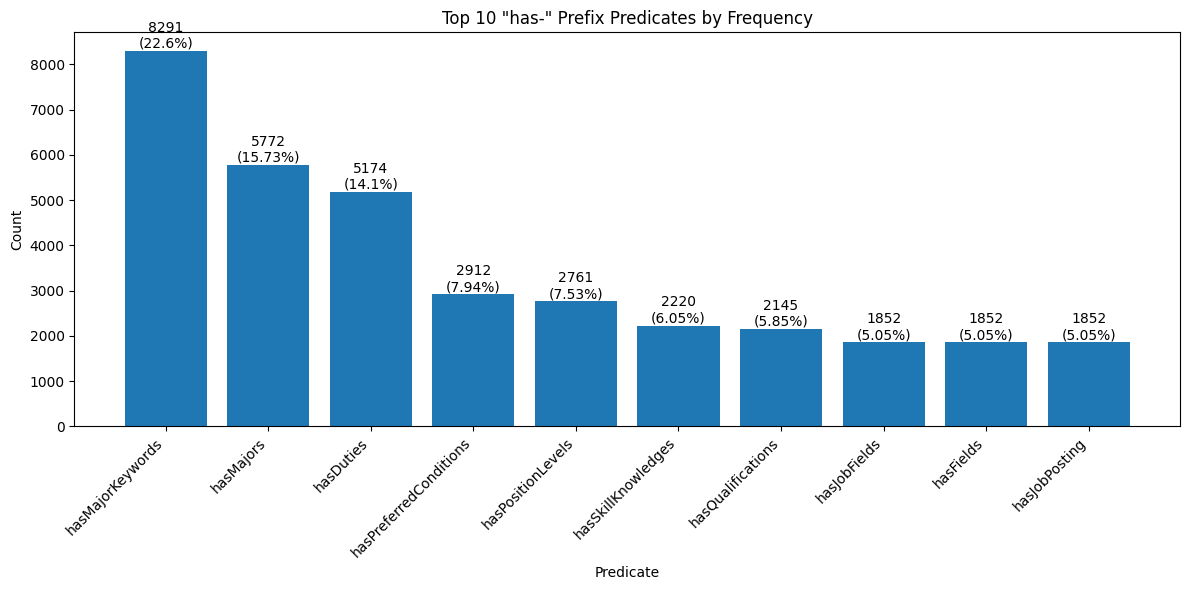

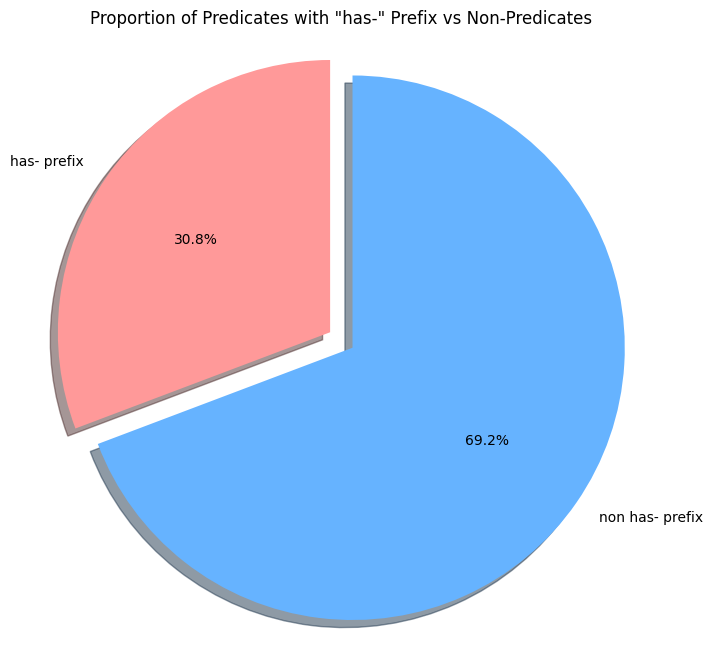

In [5]:
import os
import json
import glob
from collections import Counter
import matplotlib.pyplot as plt
from rdflib import Graph, URIRef
import pandas as pd

def load_jsonld_files(directory_path):
    """
    지정된 디렉토리에서 모든 JSON-LD 파일을 로드하고 그래프로 변환
    """
    # JSON-LD 파일 경로 가져오기
    jsonld_files = glob.glob(os.path.join(directory_path, "*-jsonld.json"))

    if not jsonld_files:
        print(f"경고: '{directory_path}' 디렉토리에 JSON-LD 파일이 없습니다.")
        return None

    # 모든 파일을 하나의 그래프로 통합
    combined_graph = Graph()

    for file_path in jsonld_files:
        try:
            # JSON-LD 파일 파싱
            graph = Graph()
            with open(file_path, 'r', encoding='utf-8') as file:
                data = json.load(file)
                # JSON 문자열로 변환 후 파싱 (rdflib 요구사항)
                json_str = json.dumps(data)
                graph.parse(data=json_str, format='json-ld')

            # 통합 그래프에 추가
            combined_graph += graph
            print(f"파일 로드 완료: {file_path}")
        except Exception as e:
            print(f"파일 파싱 중 오류 발생: {file_path}")
            print(f"오류 내용: {str(e)}")

    return combined_graph

def analyze_predicates(graph):
    """
    그래프에서 has- 접두사가 있는 predicate의 사용 빈도 및 비율 분석
    """
    if not graph or len(graph) == 0:
        print("분석할 그래프가 비어 있습니다.")
        return None

    # 모든 predicate 추출
    predicates = [p for _, p, _ in graph]

    # predicate 빈도 계산
    predicate_counter = Counter(predicates)

    # 결과를 데이터프레임으로 변환
    df = pd.DataFrame({
        'predicate': [str(p).split('/')[-1] for p in predicate_counter.keys()],
        'full_uri': [str(p) for p in predicate_counter.keys()],
        'count': list(predicate_counter.values())
    })

    # has- 접두사를 가진 predicate 식별
    df['has_prefix'] = df['predicate'].apply(lambda x: x.startswith('has'))

    # has- 접두사가 있는 predicate만 필터링
    has_prefix_df = df[df['has_prefix']].copy()

    # 비율 계산 (has- 접두사가 있는 predicate만 대상으로)
    total = has_prefix_df['count'].sum()
    has_prefix_df['percentage'] = (has_prefix_df['count'] / total * 100).round(2)

    # 빈도 기준으로 정렬
    has_prefix_df = has_prefix_df.sort_values(by='count', ascending=False).reset_index(drop=True)

    # 전체 predicate에서 has- 접두사 비율 계산
    all_total = df['count'].sum()
    has_prefix_count = df[df['has_prefix']]['count'].sum()
    non_has_prefix_count = df[~df['has_prefix']]['count'].sum()

    has_prefix_percentage = (has_prefix_count / all_total * 100).round(2)
    non_has_prefix_percentage = (non_has_prefix_count / all_total * 100).round(2)

    has_prefix_result = {
        'has_prefix_count': int(has_prefix_count),
        'non_has_prefix_count': int(non_has_prefix_count),
        'has_prefix_percentage': float(has_prefix_percentage),
        'non_has_prefix_percentage': float(non_has_prefix_percentage)
    }

    return has_prefix_df, has_prefix_result

def visualize_predicate_stats(df, has_prefix_result, output_dir):
    """
    'has-' 접두사 predicate 통계를 시각화하고 결과를 저장
    """
    # 출력 디렉토리가 없으면 생성
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # 1. 상위 10개 has- 접두사 predicate 막대 그래프
    plt.figure(figsize=(12, 6))
    top_10 = df.head(10)
    bars = plt.bar(top_10['predicate'], top_10['count'])

    # 막대 위에 값 표시
    for bar, count, percentage in zip(bars, top_10['count'], top_10['percentage']):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
                 f"{count}\n({percentage}%)",
                 ha='center', va='bottom')

    plt.title('Top 10 "has-" Prefix Predicates by Frequency')
    plt.xlabel('Predicate')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'top_10_has_predicates.png'))

    # 2. 'has-' 접두사 비율 파이 차트 (전체 predicate 중에서의 비율)
    plt.figure(figsize=(8, 8))
    labels = ['has- prefix', 'non has- prefix']
    sizes = [has_prefix_result['has_prefix_percentage'], has_prefix_result['non_has_prefix_percentage']]
    colors = ['#ff9999', '#66b3ff']
    explode = (0.1, 0)  # has- 접두사를 강조

    plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
            shadow=True, startangle=90)
    plt.axis('equal')
    plt.title('Proportion of Predicates with "has-" Prefix vs Non-Predicates')
    plt.savefig(os.path.join(output_dir, 'has_prefix_ratio.png'))

    # 3. 결과 CSV 파일로 저장
    df.to_csv(os.path.join(output_dir, 'has_predicate_statistics.csv'), index=False)

    # 4. has- 접두사 통계 저장
    with open(os.path.join(output_dir, 'has_prefix_statistics.json'), 'w', encoding='utf-8') as file:
        json.dump(has_prefix_result, file, indent=2)

    print("시각화 및 통계 파일이 저장되었습니다.")
    return True

def analyze_ontology_predicates(input_dir, output_dir):
    """
    온톨로지 파일을 분석하여 'has-' 접두사를 가진 predicate의 비율 분석 및 시각화
    """
    print(f"'{input_dir}' 디렉토리의 JSON-LD 파일 분석을 시작합니다...")

    # JSON-LD 파일 로드 및 그래프 변환
    graph = load_jsonld_files(input_dir)

    if graph is None or len(graph) == 0:
        print("분석할 그래프가 없습니다.")
        return False

    print(f"총 {len(graph)}개의 트리플을 로드했습니다.")

    # predicate 분석 (has- 접두사가 있는 것만)
    df, has_prefix_result = analyze_predicates(graph)

    # 결과 출력
    print("\n=== 'has-' 접두사 통계 ===")
    print(f"'has-' 접두사 predicate: {has_prefix_result['has_prefix_count']} ({has_prefix_result['has_prefix_percentage']}%)")
    print(f"'has-' 접두사 없는 predicate와 속성: {has_prefix_result['non_has_prefix_count']} ({has_prefix_result['non_has_prefix_percentage']}%)")

    print("\n=== 상위 10개 'has-' 접두사 predicate ===")
    print(df.head(10)[['predicate', 'count', 'percentage']])

    # 시각화 및 결과 저장
    visualize_predicate_stats(df, has_prefix_result, output_dir)

    return True

# 실행 예시
if __name__ == "__main__":
    input_dir = f"{HBN_ONTOLOGIES_DIR_PATH}/recruitments"  # JSON-LD 파일이 있는 디렉토리
    output_dir = f"{HBN_OUTPUTS_DIR_PATH}"     # 분석 결과를 저장할 디렉토리

    analyze_ontology_predicates(input_dir, output_dir)

    print("\n분석이 완료되었습니다.")
    print(f"결과 파일은 '{output_dir}' 디렉토리에 저장되었습니다.")
    print("생성된 파일:")
    print("- top_10_has_predicates.png: 상위 10개 'has-' 접두사 predicate 빈도 그래프")
    print("- has_prefix_ratio.png: 'has-' 접두사 비율 파이 차트")
    print("- has_predicate_statistics.csv: 'has-' 접두사 predicate 통계 데이터")
    print("- has_prefix_statistics.json: 'has-' 접두사 통계 데이터")

In [ ]:
#!/usr/bin/env python3
import json
import sys
import os
import glob
from pathlib import Path
import logging

# 로깅 설정
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler("json_to_jsonld_conversion.log"),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)


def read_json_file(file_path):
    """JSON 파일을 읽어 Python 객체로 변환"""
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            return json.load(file)
    except Exception as e:
        logger.error(f"파일 읽기 오류 {file_path}: {e}")
        return None


def save_jsonld_file(file_path, data):
    """Python 객체를 JSON-LD 파일로 저장"""
    try:
        # 디렉토리가 없으면 생성
        os.makedirs(os.path.dirname(file_path), exist_ok=True)

        with open(file_path, 'w', encoding='utf-8') as file:
            json.dump(data, file, ensure_ascii=False, indent=2)
        logger.info(f"저장 완료: {file_path}")
        return True
    except Exception as e:
        logger.error(f"파일 저장 오류 {file_path}: {e}")
        return False


def convert_to_jsonld(recruit_data):
    """채용정보 JSON을 JSON-LD로 변환"""
    # 기본 JSON-LD 구조 생성
    jsonld = {
        "@context": {
            "rec": "https://ontology.hibrain.net/recruitment#",
            "rdfs": "https://www.w3.org/2000/01/rdf-schema#",
            "xsd": "https://www.w3.org/2001/XMLSchema#"
        },
        "@graph": []
    }

    # RecruitId가 없는 경우 처리
    if 'RecruitId' not in recruit_data:
        logger.warning(f"RecruitId가 없는 JSON 파일: {recruit_data.get('PdfUrl', '알 수 없는 파일')}")
        recruit_id = hash(json.dumps(recruit_data, sort_keys=True))  # 해시값으로 대체
    else:
        recruit_id = recruit_data['RecruitId']

    # 채용정보 변환 (메인 Recruitment 객체)
    recruitment = {
        "@id": f"rec:recruitment_{recruit_id}",
        "@type": "rec:Recruitment",
        "rec:recruitId": recruit_id
    }

    # PdfUrl 추가 (있는 경우만)
    if 'PdfUrl' in recruit_data:
        recruitment["rec:pdfUrl"] = recruit_data['PdfUrl']

    # JobPosting 정보 추가
    if 'JobPosting' in recruit_data:
        job_posting = {
            "@type": "rec:JobPosting"
        }

        # Title 정보 추가
        if 'Title' in recruit_data['JobPosting']:
            job_posting["rec:title"] = recruit_data['JobPosting']['Title']

        # Organization 정보 추가
        if 'Organization' in recruit_data['JobPosting']:
            job_posting["rec:hasOrganization"] = {
                "@type": "rec:Organization",
                "rec:organizationName": recruit_data['JobPosting']['Organization']
            }

        # Location 정보 추가
        if 'Location' in recruit_data['JobPosting']:
            job_posting["rec:hasLocation"] = {
                "@type": "rec:Location",
                "rec:locationName": recruit_data['JobPosting']['Location']
            }

        recruitment["rec:hasJobPosting"] = job_posting

    # JobFields 처리 (배열일 수 있음)
    if 'JobFields' in recruit_data and recruit_data['JobFields']:
        # 모든 JobField 처리
        job_fields = []
        for job_field in recruit_data['JobFields']:
            job_field_obj = {
                "@type": "rec:JobField"
            }

            # Department 정보 추가
            if 'Department' in job_field:
                job_field_obj["rec:hasDepartment"] = {
                    "@type": "rec:Department",
                    "rec:departmentName": job_field['Department']
                }

                department_obj = job_field_obj["rec:hasDepartment"]

                # Department 위치 처리
                if 'DepartmentLocations' in job_field:
                    department_obj["rec:hasLocation"] = [
                        {
                            "@type": "rec:Location",
                            "rec:locationName": location
                        }
                        for location in job_field['DepartmentLocations']
                    ]
                elif 'JobPosting' in recruit_data and 'Location' in recruit_data['JobPosting']:
                    department_obj["rec:hasLocation"] = {
                        "@type": "rec:Location",
                        "rec:locationName": recruit_data['JobPosting']['Location']
                    }

                # Fields 처리 (배열일 수 있음)
                if 'Fields' in job_field and job_field['Fields']:
                    recruitment_fields = []
                    for field in job_field['Fields']:
                        recruitment_field = {
                            "@type": "rec:RecruitmentField"
                        }

                        # RecruitmentField 이름 추가
                        if 'RecruitmentField' in field:
                            recruitment_field["rec:fieldName"] = field['RecruitmentField']

                        # Duties 처리
                        if 'Duties' in field and field['Duties']:
                            recruitment_field["rec:hasDuty"] = [
                                {
                                    "@type": "rec:Duty",
                                    "rec:dutyDescription": duty
                                }
                                for duty in field['Duties']
                            ]

                        # PositionLevels 처리
                        if 'PositionLevels' in field and field['PositionLevels']:
                            recruitment_field["rec:hasPositionLevel"] = [
                                {
                                    "@type": "rec:PositionLevel",
                                    "rec:positionLevelName": level
                                }
                                for level in field['PositionLevels']
                            ]

                        # Qualifications 처리
                        if 'Qualifications' in field and field['Qualifications']:
                            recruitment_field["rec:hasQualification"] = [
                                {
                                    "@type": "rec:Qualification",
                                    "rec:qualificationDescription": qual
                                }
                                for qual in field['Qualifications']
                            ]

                        # PreferredConditions 처리
                        if 'PreferredConditions' in field and field['PreferredConditions']:
                            recruitment_field["rec:hasPreference"] = [
                                {
                                    "@type": "rec:Preference",
                                    "rec:preferenceDescription": pref
                                }
                                for pref in field['PreferredConditions']
                            ]

                        # Majors 처리
                        if 'Majors' in field and field['Majors']:
                            majors = []
                            for major in field['Majors']:
                                major_obj = {
                                    "@type": "rec:Major",
                                    "rec:majorName": major
                                }

                                # MajorKeywords 처리 (있다면)
                                if 'MajorKeywords' in field and field['MajorKeywords']:
                                    major_obj["rec:hasMajorKeyword"] = [
                                        {
                                            "@type": "rec:MajorKeyword",
                                            "rec:keywordName": keyword
                                        }
                                        for keyword in field['MajorKeywords']
                                    ]

                                majors.append(major_obj)

                            recruitment_field["rec:hasMajor"] = majors

                        # SkillKnowledges 처리
                        if 'SkillKnowledges' in field and field['SkillKnowledges']:
                            recruitment_field["rec:hasSkill"] = [
                                {
                                    "@type": "rec:Skill",
                                    "rec:skillDescription": skill
                                }
                                for skill in field['SkillKnowledges']
                            ]

                        recruitment_fields.append(recruitment_field)

                    department_obj["rec:hasRecruitmentField"] = recruitment_fields

            job_fields.append(job_field_obj)

        if job_fields:
            recruitment["rec:hasJobField"] = job_fields

    # 전체 Requirements 처리
    if 'Requirements' in recruit_data and recruit_data['Requirements']:
        recruitment["rec:hasRequirement"] = [
            {
                "@type": "rec:Requirement",
                "rec:requirementDescription": req
            }
            for req in recruit_data['Requirements']
        ]

    # 전체 Preferences 처리
    if 'Preferences' in recruit_data and recruit_data['Preferences']:
        recruitment["rec:hasPreference"] = [
            {
                "@type": "rec:Preference",
                "rec:preferenceDescription": pref
            }
            for pref in recruit_data['Preferences']
        ]

    # 그래프에 추가
    jsonld["@graph"].append(recruitment)
    return jsonld


def find_all_json_files(directory):
    """디렉토리 내 모든 JSON 파일 경로 찾기 (재귀적으로)"""
    json_files = []

    # 경로 객체 생성
    dir_path = Path(directory)

    # 모든 JSON 파일 찾기 (대소문자 무관)
    for json_path in dir_path.glob('**/*.json'):
        json_files.append(str(json_path))

    return json_files


def main():
    logger.info("변환 프로세스 시작")

    # 출력 디렉토리 확인 및 생성
    os.makedirs(HBN_ONTOLOGY_DIR_PATH, exist_ok=True)

    # 모든 JSON 파일 찾기
    json_files = find_all_json_files(HBN_RECRUITS_DIR_PATH)
    logger.info(f"총 {len(json_files)}개의 JSON 파일을 찾았습니다.")

    success_count = 0
    error_count = 0

    for json_file in json_files:
        # 상대 경로 추출 (폴더 구조 유지를 위해)
        rel_path = os.path.relpath(json_file, HBN_RECRUITS_DIR_PATH)

        # 출력 파일 경로 생성 (확장자만 변경)
        output_file = os.path.join(
            HBN_ONTOLOGY_DIR_PATH,
            os.path.splitext(rel_path)[0] + '.jsonld'
        )

        logger.info(f"처리 중: {json_file}")

        # JSON 파일 읽기
        recruit_data = read_json_file(json_file)
        if recruit_data is None:
            error_count += 1
            continue

        # JSON-LD로 변환
        try:
            jsonld_data = convert_to_jsonld(recruit_data)

            # JSON-LD 파일 저장
            if save_jsonld_file(output_file, jsonld_data):
                success_count += 1
            else:
                error_count += 1
        except Exception as e:
            logger.error(f"변환 중 오류 발생 {json_file}: {e}")
            error_count += 1

    logger.info(f"변환 완료: 성공 {success_count}개, 실패 {error_count}개")
    logger.info(f"변환된 파일은 {HBN_ONTOLOGY_DIR_PATH} 디렉토리에 저장되었습니다.")


if __name__ == "__main__":
    main()

In [ ]:
#!/usr/bin/env python3
import os
import json
import logging
from pathlib import Path
import multiprocessing
from concurrent.futures import ProcessPoolExecutor, as_completed
import time
import re

# 로깅 설정
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)


def search_in_file(file_path, keywords):
    """
    단일 JSON-LD 파일 내에서 키워드 검색을 수행합니다.
    rdflib를 사용하지 않고 JSON 직접 파싱하여 검색합니다.
    """
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)

        # 파일에 그래프가 없으면 빈 리스트 반환
        if '@graph' not in data:
            return []

        jobs = []
        # 정규 표현식으로 키워드 패턴 컴파일 (성능 향상)
        patterns = [re.compile(keyword, re.IGNORECASE) for keyword in keywords]

        # 문자열로 변환하여 검색 (간단한 방법이지만 효과적)
        file_content_str = json.dumps(data, ensure_ascii=False).lower()

        # 키워드 매칭 여부 확인
        match_found = False
        for pattern in patterns:
            if pattern.search(file_content_str):
                match_found = True
                break

        # 키워드가 매칭되지 않으면 빈 리스트 반환
        if not match_found:
            return []

        # 키워드가 매칭됐을 때만 자세한 분석 수행
        for item in data['@graph']:
            # Recruitment 타입인지 확인
            if '@type' in item and 'Recruitment' in item['@type']:
                job_info = extract_job_info(item)
                if job_info:
                    # 검색어가 실제로 포함되어 있는지 다시 한번 확인
                    job_info_str = json.dumps(job_info, ensure_ascii=False).lower()
                    for pattern in patterns:
                        if pattern.search(job_info_str):
                            jobs.append(job_info)
                            break

        return jobs

    except Exception as e:
        logger.error(f"파일 처리 오류 {file_path}: {e}")
        return []


def extract_job_info(recruitment_data):
    """
    Recruitment 데이터에서 채용 정보를 추출합니다.
    """
    job_info = {}

    # JobPosting 정보 추출
    if 'rec:hasJobPosting' in recruitment_data:
        job_posting = recruitment_data['rec:hasJobPosting']

        # 제목 추출
        if 'rec:title' in job_posting:
            job_info['title'] = job_posting['rec:title']

        # 기관 추출
        if 'rec:hasOrganization' in job_posting and 'rec:organizationName' in job_posting['rec:hasOrganization']:
            job_info['organization'] = job_posting['rec:hasOrganization']['rec:organizationName']

        # 위치 추출
        if 'rec:hasLocation' in job_posting and 'rec:locationName' in job_posting['rec:hasLocation']:
            job_info['location'] = job_posting['rec:hasLocation']['rec:locationName']

    # JobField 정보 추출
    if 'rec:hasJobField' in recruitment_data:
        job_fields = recruitment_data['rec:hasJobField']
        if not isinstance(job_fields, list):
            job_fields = [job_fields]

        for job_field in job_fields:
            if 'rec:hasDepartment' in job_field:
                dept = job_field['rec:hasDepartment']

                # 부서 추출
                if 'rec:departmentName' in dept:
                    job_info['department'] = dept['rec:departmentName']

                # 모집 분야 추출
                if 'rec:hasRecruitmentField' in dept:
                    fields = dept['rec:hasRecruitmentField']
                    if not isinstance(fields, list):
                        fields = [fields]

                    for field in fields:
                        # 분야명 추출
                        if 'rec:fieldName' in field:
                            job_info['field'] = field['rec:fieldName']

                        # 전공 추출
                        if 'rec:hasMajor' in field:
                            majors = field['rec:hasMajor']
                            if not isinstance(majors, list):
                                majors = [majors]

                            for major in majors:
                                if 'rec:majorName' in major:
                                    job_info['major'] = major['rec:majorName']
                                    break

                        # 직급 추출
                        if 'rec:hasPositionLevel' in field:
                            position_levels = field['rec:hasPositionLevel']
                            if not isinstance(position_levels, list):
                                position_levels = [position_levels]

                            for position in position_levels:
                                if 'rec:positionLevelName' in position:
                                    job_info['position_level'] = position['rec:positionLevelName']
                                    break

    return job_info


def process_batch(batch_files, keywords):
    """배치로 파일들을 처리합니다."""
    batch_results = []
    for file_path in batch_files:
        batch_results.extend(search_in_file(file_path, keywords))
    return batch_results


def search_ai_jobs_parallel(jsonld_dir, keywords, num_processes=None, batch_size=50):
    """
    멀티프로세싱을 사용하여 JSON-LD 파일에서 인공지능 관련 채용정보를 병렬로 검색합니다.
    """
    # 사용할 프로세스 수 결정
    if num_processes is None:
        num_processes = max(1, multiprocessing.cpu_count() - 1)

    # JSON-LD 파일 찾기
    start_time = time.time()
    jsonld_files = list(Path(jsonld_dir).glob('**/*.jsonld'))
    logger.info(f"총 {len(jsonld_files)}개의 JSON-LD 파일을 찾았습니다. (소요시간: {time.time() - start_time:.2f}초)")

    if not jsonld_files:
        return []

    # 파일들을 배치로 나누기
    batches = [jsonld_files[i:i + batch_size] for i in range(0, len(jsonld_files), batch_size)]
    logger.info(f"총 {len(batches)}개 배치로 처리합니다. 프로세스 수: {num_processes}")

    # 병렬 처리
    jobs = []
    start_time = time.time()
    with ProcessPoolExecutor(max_workers=num_processes) as executor:
        # 각 배치를 병렬로 처리
        futures = [executor.submit(process_batch, batch, keywords) for batch in batches]

        # 진행 상황 표시
        completed = 0
        for future in as_completed(futures):
            completed += 1
            if completed % 10 == 0 or completed == len(batches):
                logger.info(f"진행 상황: {completed}/{len(batches)} 배치 처리 완료 ({(completed / len(batches)) * 100:.1f}%)")

            try:
                result = future.result()
                jobs.extend(result)
            except Exception as e:
                logger.error(f"배치 처리 중 오류 발생: {e}")

    logger.info(f"총 {len(jobs)}개의 인공지능 관련 채용정보를 찾았습니다. (소요시간: {time.time() - start_time:.2f}초)")
    return jobs


def remove_duplicates(jobs):
    """중복된 채용정보를 제거합니다."""
    unique_jobs = []
    seen_titles = set()

    for job in jobs:
        # 제목과 기관을 기준으로 중복 체크
        key = (job.get('title', ''), job.get('organization', ''))
        if key not in seen_titles:
            seen_titles.add(key)
            unique_jobs.append(job)

    logger.info(f"중복 제거 후 {len(unique_jobs)}개의 채용정보가 남았습니다.")
    return unique_jobs


def print_job_results(jobs):
    """
    검색 결과를 보기 좋게 출력합니다.
    """
    if not jobs:
        print("\n⚠️ 검색 결과가 없습니다.")
        return

    print(f"\n📋 총 {len(jobs)}개의 인공지능 관련 채용정보를 찾았습니다.\n")

    for i, job in enumerate(jobs, 1):
        print(f"🔍 채용정보 {i}")
        print(f"  제목: {job.get('title', '정보 없음')}")
        print(f"  기관: {job.get('organization', '정보 없음')}")
        print(f"  지역: {job.get('location', '정보 없음')}")
        print(f"  부서: {job.get('department', '정보 없음')}")
        print(f"  분야: {job.get('field', '정보 없음')}")
        print(f"  전공: {job.get('major', '정보 없음')}")
        print(f"  직급: {job.get('position_level', '정보 없음')}")
        print()


def save_results_to_json(jobs, output_file):
    """
    검색 결과를 JSON 파일로 저장합니다.
    """
    try:
        with open(output_file, 'w', encoding='utf-8') as f:
            json.dump(jobs, f, ensure_ascii=False, indent=2)
        logger.info(f"검색 결과가 {output_file}에 저장되었습니다.")
        return True
    except Exception as e:
        logger.error(f"파일 저장 오류: {e}")
        return False


def main():
    # 시작 시간
    total_start_time = time.time()

    # 변수 설정
    jsonld_dir = HBN_ONTOLOGY_DIR_PATH  # JSON-LD 파일 디렉토리 경로

    # 검색 키워드 - 여기서 직접 설정
    keywords = ["인공지능", "AI", "머신러닝", "딥러닝", "데이터 사이언스"]

    # 출력 파일 설정
    output_file = "ai_jobs_result.json"

    # 프로세스 수 - 시스템의 코어 수에 따라 자동 설정
    # Apple Silicon(M1/M2/M3)은 성능 코어와 효율 코어가 있으므로 전체 코어수-1로 설정
    num_processes = max(1, multiprocessing.cpu_count() - 1)

    # 배치 크기 - 파일 수가 많을 때 메모리 관리를 위해 조정
    batch_size = 100

    # 로그 메시지
    logger.info(f"JSON-LD 파일 디렉토리: {jsonld_dir}")
    logger.info(f"검색 키워드: {', '.join(keywords)}")
    logger.info(f"사용할 프로세스 수: {num_processes}, 배치 크기: {batch_size}")

    # 병렬 검색 실행
    jobs = search_ai_jobs_parallel(jsonld_dir, keywords, num_processes, batch_size)

    # 중복 제거
    unique_jobs = remove_duplicates(jobs)

    # 결과 출력
    print_job_results(unique_jobs)

    # 결과 저장
    save_results_to_json(unique_jobs, output_file)

    # 총 소요 시간
    logger.info(f"총 소요 시간: {time.time() - total_start_time:.2f}초")


if __name__ == "__main__":
    main()


📋 총 273개의 인공지능 관련 채용정보를 찾았습니다.

🔍 채용정보 1
  제목: KAIST 인공위성연구소 [위촉연구원] 모집 공고
  기관: KAIST 인공위성연구소
  지역: 대전
  부서: 인공위성연구소
  분야: 광학위성 영상처리 및 위성정보 활용 연구
  전공: 원격탐사
  직급: 위촉연구원

🔍 채용정보 2
  제목: 국립순천대학교 2024-2학기 교수 초빙 공고
  기관: 국립순천대학교
  지역: 전라남도 순천시
  부서: 교육혁신본부 교양교육원
  분야: 인공지능(AI) 융합교육
  전공: 컴퓨터교육
  직급: 교수

🔍 채용정보 3
  제목: KAIST 전기및전자공학부 전임직 교원 채용
  기관: KAIST
  지역: 대전
  부서: 전기및전자공학부
  분야: 반도체 소자 및 디스플레이 소자
  전공: 전기공학
  직급: 전임직 교원

🔍 채용정보 4
  제목: KAIST 전기공학부 전임교원 채용공고
  기관: KAIST
  지역: 대전
  부서: 전기공학부
  분야: 반도체 및 디스플레이 소자
  전공: 전기공학
  직급: 전임교원

🔍 채용정보 5
  제목: KAIST 문술미래전략대학원 연구교원 채용
  기관: KAIST
  지역: 대전
  부서: 문술미래전략대학원 데이터 전략 연구실(DS Lab@KAIST)
  분야: 공학 및 사회과학 전 분야
  전공: 공학
  직급: 연구교원(전일제)

🔍 채용정보 6
  제목: 한국과학기술원 부설 고등과학원 2024년-1차 AI기초과학센터 연구원 모집 공고
  기관: 한국과학기술원 부설 고등과학원
  지역: 서울시 동대문구 회기로 85
  부서: AI기초과학센터
  분야: 수학/물리/계산과학 AI 연구원
  전공: 수학
  직급: AI 연구원

🔍 채용정보 7
  제목: KAIST 산업디자인학과 전임직교원 초빙
  기관: KAIST
  지역: 대전
  부서: 산업디자인학과
  분야: 시각 커뮤니케이션
  전공: 디자인
  직급: 신입+경력

🔍 채용정보 8
  제목: KIAS 2024-1 Recr

In [ ]:
#!/usr/bin/env python3
import os
import json
import logging
from pathlib import Path
import multiprocessing
from concurrent.futures import ProcessPoolExecutor, as_completed
import time
import re
from rdflib import Graph, Namespace, URIRef, Literal
from rdflib.namespace import RDF, RDFS
from rdflib.plugins.sparql import prepareQuery

# 로깅 설정
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# 네임스페이스 정의
REC = Namespace("https://ontology.hibrain.net/recruitment#")


def find_match_reason(job_data, keywords, file_content=None):
    """
    채용정보에서 어떤 키워드가 매치되었는지 찾습니다.
    """
    # 각 필드별로 키워드가 어디에 있는지 정확히 찾기
    fields_to_check = [
        ('title', '제목'),
        ('organization', '기관'),
        ('department', '부서'),
        ('field', '분야'),
        ('major', '전공'),
        ('position_level', '직급')
    ]

    field_matches = []
    for field_key, field_name in fields_to_check:
        if field_key in job_data:
            field_value = job_data[field_key].lower()
            for keyword in keywords:
                if keyword.lower() in field_value:
                    field_matches.append(f"{field_name}의 '{job_data[field_key]}'에서 '{keyword}' 매치")

    if field_matches:
        return "; ".join(field_matches)

    # 전체 채용정보 JSON에서 키워드 찾기
    job_str = json.dumps(job_data, ensure_ascii=False).lower()
    job_matched_keywords = []

    for keyword in keywords:
        if keyword.lower() in job_str:
            job_matched_keywords.append(keyword)

    if job_matched_keywords:
        return f"채용정보 JSON에서 키워드 발견: {', '.join(job_matched_keywords)} (특정 필드는 알 수 없음)"

    # 파일 내용에서 키워드 찾기
    if file_content:
        file_content_lower = file_content.lower()
        file_matches = []
        for keyword in keywords:
            if keyword.lower() in file_content_lower:
                file_matches.append(keyword)

        if file_matches:
            return f"파일 내용에서만 키워드 발견: {', '.join(file_matches)} (채용정보 필드에는 없음)"

    return "매치 이유를 찾을 수 없음 (SPARQL 쿼리 결과)"


def find_keyword_in_file(file_content, keywords):
    """
    파일 내용에서 키워드를 찾고 매치된 키워드 목록을 반환합니다.
    """
    matched_keywords = []
    file_content_lower = file_content.lower()

    for keyword in keywords:
        if keyword.lower() in file_content_lower:
            matched_keywords.append(keyword)

    return matched_keywords


def process_file_with_sparql(file_path, sparql_query, keywords):
    """
    단일 JSON-LD 파일에 SPARQL 쿼리를 적용합니다.
    """
    try:
        # 파일 내용 읽기
        file_content = None
        with open(file_path, 'r', encoding='utf-8') as f:
            file_content = f.read()

        # 파일에서 키워드 찾기
        matched_keywords = find_keyword_in_file(file_content, keywords)

        # 키워드가 매치되지 않으면 빈 리스트 반환
        if not matched_keywords:
            return []

        # 그래프 생성 및 파일 로드
        g = Graph()
        g.bind("rec", REC)
        g.parse(data=file_content, format='json-ld')

        # SPARQL 쿼리 실행
        results = g.query(sparql_query)

        # 결과 처리
        jobs = []
        for row in results:
            # 채용공고 ID 추출
            recruit_id = None
            if hasattr(row, 'recruitment') and row.recruitment:
                recruit_id_parts = str(row.recruitment).split('/')
                if recruit_id_parts:
                    recruit_id = recruit_id_parts[-1]

            job = {
                "recruit_id": recruit_id,
                "title": row.title.value if row.title else None,
                "organization": row.orgName.value if hasattr(row, 'orgName') and row.orgName else None,
                "location": row.location.value if hasattr(row, 'location') and row.location else None,
                "department": row.department.value if hasattr(row, 'department') and row.department else None,
                "field": row.fieldName.value if hasattr(row, 'fieldName') and row.fieldName else None,
                "major": row.majorName.value if hasattr(row, 'majorName') and row.majorName else None,
                "position_level": row.positionLevel.value if hasattr(row,
                                                                     'positionLevel') and row.positionLevel else None
            }

            # None 값 제거
            job = {k: v for k, v in job.items() if v is not None}

            if job:  # 비어있지 않은 결과만 추가
                # 매치 이유 및 키워드 추가
                job["match_reason"] = find_match_reason(job, keywords, file_content)
                job["matched_keywords"] = matched_keywords

                # 파일 경로 추가 (디버깅용)
                job["source_file"] = str(file_path)

                # SPARQL 쿼리 결과에서 키워드 검증
                valid_match = False
                for keyword in keywords:
                    for value in job.values():
                        if isinstance(value, str) and keyword.lower() in value.lower():
                            valid_match = True
                            break
                    if valid_match:
                        break

                # 키워드가 실제 채용정보 필드에 있거나, match_reason이 "파일 내용에서만 키워드 발견"인 경우만 추가
                if valid_match or "파일 내용에서만 키워드 발견" in job["match_reason"]:
                    jobs.append(job)

        return jobs

    except Exception as e:
        logger.error(f"파일 처리 오류 {file_path}: {e}")
        return []


def process_batch(batch_files, sparql_query, keywords):
    """배치로 파일들을 처리합니다."""
    batch_results = []
    for file_path in batch_files:
        batch_results.extend(process_file_with_sparql(file_path, sparql_query, keywords))
    return batch_results


def create_ai_sparql_query(keywords):
    """
    인공지능 관련 채용정보를 검색하는 SPARQL 쿼리를 생성합니다.
    """
    # SPARQL 쿼리 생성
    keyword_filters = []
    for keyword in keywords:
        keyword_filters.append(f'CONTAINS(LCASE(?title), LCASE("{keyword}"))')
        keyword_filters.append(f'CONTAINS(LCASE(?fieldName), LCASE("{keyword}"))')
        keyword_filters.append(f'CONTAINS(LCASE(?majorName), LCASE("{keyword}"))')
        keyword_filters.append(f'CONTAINS(LCASE(?keywordName), LCASE("{keyword}"))')
        keyword_filters.append(f'CONTAINS(LCASE(?skillDesc), LCASE("{keyword}"))')
        keyword_filters.append(f'CONTAINS(LCASE(?dutyDesc), LCASE("{keyword}"))')

    keyword_filter_str = " || ".join(keyword_filters)

    query = f"""
    PREFIX rec: <{REC}>

    SELECT DISTINCT ?recruitment ?title ?orgName ?location ?department ?fieldName ?majorName ?positionLevel ?keywordName ?skillDesc ?dutyDesc
    WHERE {{
      ?recruitment a rec:Recruitment ;
                   rec:hasJobPosting ?posting .

      ?posting rec:title ?title .

      OPTIONAL {{
        ?posting rec:hasOrganization/rec:organizationName ?orgName .
      }}

      OPTIONAL {{
        ?posting rec:hasLocation/rec:locationName ?location .
      }}

      OPTIONAL {{
        ?recruitment rec:hasJobField ?jobField .
        ?jobField rec:hasDepartment ?dept .
        ?dept rec:departmentName ?department .

        OPTIONAL {{
          ?dept rec:hasRecruitmentField ?field .
          ?field rec:fieldName ?fieldName .

          OPTIONAL {{
            ?field rec:hasMajor/rec:majorName ?majorName .
          }}

          OPTIONAL {{
            ?field rec:hasMajor/rec:hasMajorKeyword/rec:keywordName ?keywordName .
          }}

          OPTIONAL {{
            ?field rec:hasPositionLevel/rec:positionLevelName ?positionLevel .
          }}

          OPTIONAL {{
            ?field rec:hasSkill/rec:skillDescription ?skillDesc .
          }}

          OPTIONAL {{
            ?field rec:hasDuty/rec:dutyDescription ?dutyDesc .
          }}
        }}
      }}

      FILTER({keyword_filter_str})
    }}
    LIMIT 1000
    """

    return query


def fast_filter_files(files, keywords):
    """
    파일을 먼저 빠르게 필터링하여 키워드가 포함된 파일만 반환합니다.
    """
    filtered_files = []
    keyword_patterns = [re.compile(r'\b' + re.escape(kw) + r'\b', re.IGNORECASE) for kw in keywords]

    for file_path in files:
        try:
            # 파일 내용을 문자열로 읽기
            with open(file_path, 'r', encoding='utf-8') as f:
                content = f.read(20000)  # 처음 20KB만 읽기

            # 단어 경계를 고려한 키워드 검색
            if any(pattern.search(content) for pattern in keyword_patterns):
                filtered_files.append(file_path)
        except Exception as e:
            logger.error(f"파일 필터링 오류 {file_path}: {e}")

    return filtered_files


def search_ai_jobs_parallel(jsonld_dir, keywords, num_processes=None, batch_size=20):
    """
    멀티프로세싱을 사용하여 JSON-LD 파일에서 인공지능 관련 채용정보를 병렬로 검색합니다.
    """
    # 사용할 프로세스 수 결정
    if num_processes is None:
        num_processes = max(1, multiprocessing.cpu_count() - 1)

    # JSON-LD 파일 찾기
    start_time = time.time()
    jsonld_files = list(Path(jsonld_dir).glob('**/*.jsonld'))
    logger.info(f"총 {len(jsonld_files)}개의 JSON-LD 파일을 찾았습니다. (소요시간: {time.time() - start_time:.2f}초)")

    if not jsonld_files:
        return []

    # 빠른 필터링으로 키워드가 포함된 파일만 선택
    start_time = time.time()
    filtered_files = fast_filter_files(jsonld_files, keywords)
    logger.info(f"키워드 필터링 후 {len(filtered_files)}개 파일이 남았습니다. (소요시간: {time.time() - start_time:.2f}초)")

    if not filtered_files:
        return []

    # SPARQL 쿼리 생성
    sparql_query = create_ai_sparql_query(keywords)

    # 파일들을 배치로 나누기
    batches = [filtered_files[i:i + batch_size] for i in range(0, len(filtered_files), batch_size)]
    logger.info(f"총 {len(batches)}개 배치로 처리합니다. 프로세스 수: {num_processes}")

    # 병렬 처리
    jobs = []
    start_time = time.time()
    with ProcessPoolExecutor(max_workers=num_processes) as executor:
        # 각 배치를 병렬로 처리
        futures = [executor.submit(process_batch, batch, sparql_query, keywords) for batch in batches]

        # 진행 상황 표시
        completed = 0
        for future in as_completed(futures):
            completed += 1
            if completed % 10 == 0 or completed == len(batches):
                logger.info(f"진행 상황: {completed}/{len(batches)} 배치 처리 완료 ({(completed / len(batches)) * 100:.1f}%)")

            try:
                result = future.result()
                jobs.extend(result)
            except Exception as e:
                logger.error(f"배치 처리 중 오류 발생: {e}")

    logger.info(f"총 {len(jobs)}개의 인공지능 관련 채용정보를 찾았습니다. (소요시간: {time.time() - start_time:.2f}초)")
    return jobs


def remove_duplicates(jobs):
    """중복된 채용정보를 제거합니다."""
    unique_jobs = []
    seen_titles = set()

    for job in jobs:
        # 제목과 기관을 기준으로 중복 체크
        key = (job.get('title', ''), job.get('organization', ''))
        if key not in seen_titles:
            seen_titles.add(key)
            unique_jobs.append(job)

    logger.info(f"중복 제거 후 {len(unique_jobs)}개의 채용정보가 남았습니다.")
    return unique_jobs


def print_job_results(jobs):
    """
    검색 결과를 보기 좋게 출력합니다.
    """
    if not jobs:
        print("\n⚠️ 검색 결과가 없습니다.")
        return

    print(f"\n📋 총 {len(jobs)}개의 인공지능 관련 채용정보를 찾았습니다.\n")

    for i, job in enumerate(jobs, 1):
        print(f"🔍 채용정보 {i}")
        print(f"  채용ID: {job.get('recruit_id', '정보 없음')}")
        print(f"  제목: {job.get('title', '정보 없음')}")
        print(f"  기관: {job.get('organization', '정보 없음')}")
        print(f"  지역: {job.get('location', '정보 없음')}")
        print(f"  부서: {job.get('department', '정보 없음')}")
        print(f"  분야: {job.get('field', '정보 없음')}")
        print(f"  전공: {job.get('major', '정보 없음')}")
        print(f"  직급: {job.get('position_level', '정보 없음')}")
        print(f"  매치 이유: {job.get('match_reason', '정보 없음')}")
        if 'matched_keywords' in job:
            print(f"  매치된 키워드: {', '.join(job['matched_keywords'])}")
        if 'source_file' in job:
            print(f"  소스 파일: {job['source_file']}")
        print()


def save_results_to_json(jobs, output_file):
    """
    검색 결과를 JSON 파일로 저장합니다.
    """
    try:
        with open(output_file, 'w', encoding='utf-8') as f:
            json.dump(jobs, f, ensure_ascii=False, indent=2)
        logger.info(f"검색 결과가 {output_file}에 저장되었습니다.")
        return True
    except Exception as e:
        logger.error(f"파일 저장 오류: {e}")
        return False


def analyze_results(jobs, keywords):
    """
    결과를 분석하여 매치 정보를 출력합니다.
    """
    if not jobs:
        return

    # 키워드별 매치 수 분석
    keyword_match_count = {keyword: 0 for keyword in keywords}
    for job in jobs:
        if 'matched_keywords' in job:
            for kw in job['matched_keywords']:
                if kw in keyword_match_count:
                    keyword_match_count[kw] += 1

    # 매치 이유 분석
    match_reasons = {}
    for job in jobs:
        reason = job.get('match_reason', '알 수 없음')
        match_reasons[reason] = match_reasons.get(reason, 0) + 1

    # 출력
    print("\n📊 검색 결과 분석")
    print("  키워드별 매치 수:")
    for kw, count in keyword_match_count.items():
        print(f"    - {kw}: {count}개")

    print("\n  매치 이유 분포:")
    for reason, count in sorted(match_reasons.items(), key=lambda x: x[1], reverse=True)[:10]:
        print(f"    - {reason}: {count}개")

    if len(match_reasons) > 10:
        print(
            f"    - 기타: {sum(count for reason, count in sorted(match_reasons.items(), key=lambda x: x[1], reverse=True)[10:])}개")


def main():
    # 시작 시간
    total_start_time = time.time()

    # 변수 설정
    jsonld_dir = HBN_ONTOLOGY_DIR_PATH  # JSON-LD 파일 디렉토리 경로

    # 검색 키워드 - 여기서 직접 설정
    keywords = ["인공지능", "AI", "머신러닝", "딥러닝", "데이터 사이언스"]

    # 출력 파일 설정
    output_file = f"{HBN_OUTPUT_DIR_PATH}/recruitments/ai_jobs_result.json"

    # 프로세스 수 - 시스템의 코어 수에 따라 자동 설정
    # Apple Silicon(M1/M2/M3)은 성능 코어와 효율 코어가 있으므로 적절히 조정
    num_processes = max(1, multiprocessing.cpu_count() - 1)

    # 배치 크기 - 파일 수가 많을 때 메모리 관리를 위해 조정
    # SPARQL 쿼리는 메모리를 많이 사용하므로 작은 배치 크기 사용
    batch_size = 20

    # 로그 메시지
    logger.info(f"JSON-LD 파일 디렉토리: {jsonld_dir}")
    logger.info(f"검색 키워드: {', '.join(keywords)}")
    logger.info(f"사용할 프로세스 수: {num_processes}, 배치 크기: {batch_size}")

    # 병렬 검색 실행
    jobs = search_ai_jobs_parallel(jsonld_dir, keywords, num_processes, batch_size)

    # 중복 제거
    unique_jobs = remove_duplicates(jobs)

    # 결과 분석
    analyze_results(unique_jobs, keywords)

    # 결과 출력
    print_job_results(unique_jobs)

    # 결과 저장
    save_results_to_json(unique_jobs, output_file)

    # 총 소요 시간
    logger.info(f"총 소요 시간: {time.time() - total_start_time:.2f}초")


if __name__ == "__main__":
    main()

ERROR:__main__:파일 저장 오류: [Errno 2] No such file or directory: '/content/drive/MyDrive/Workspaces/Hibrainnet/output/recruitments/ai_jobs_result.json'



📊 검색 결과 분석
  키워드별 매치 수:
    - 인공지능: 345개
    - AI: 499개
    - 머신러닝: 54개
    - 딥러닝: 53개
    - 데이터 사이언스: 18개

  매치 이유 분포:
    - 파일 내용에서만 키워드 발견: 인공지능, AI (채용정보 필드에는 없음): 84개
    - 파일 내용에서만 키워드 발견: AI (채용정보 필드에는 없음): 58개
    - 전공의 '인공지능'에서 '인공지능' 매치: 11개
    - 파일 내용에서만 키워드 발견: 인공지능, AI, 머신러닝 (채용정보 필드에는 없음): 9개
    - 파일 내용에서만 키워드 발견: AI, 머신러닝, 딥러닝 (채용정보 필드에는 없음): 8개
    - 파일 내용에서만 키워드 발견: 인공지능, AI, 머신러닝, 딥러닝 (채용정보 필드에는 없음): 7개
    - 파일 내용에서만 키워드 발견: AI, 머신러닝 (채용정보 필드에는 없음): 5개
    - 파일 내용에서만 키워드 발견: AI, 딥러닝 (채용정보 필드에는 없음): 4개
    - 전공의 '데이터 사이언스'에서 '데이터 사이언스' 매치: 3개
    - 파일 내용에서만 키워드 발견: 인공지능, AI, 딥러닝 (채용정보 필드에는 없음): 3개
    - 기타: 307개

📋 총 499개의 인공지능 관련 채용정보를 찾았습니다.

🔍 채용정보 1
  채용ID: recruitment#recruitment_3469678
  제목: KAIST 인공위성연구소 [위촉연구원] 모집 공고
  기관: KAIST 인공위성연구소
  지역: 대전
  부서: 인공위성연구소
  분야: 위성 시스템엔지니어링
  전공: 항공우주공학
  직급: 위촉연구원
  매치 이유: 제목의 'KAIST 인공위성연구소 [위촉연구원] 모집 공고'에서 'AI' 매치; 기관의 'KAIST 인공위성연구소'에서 'AI' 매치
  매치된 키워드: 인공지능, AI, 딥러닝
  소스 파일: /content/drive/MyDrive/Workspaces/Hibra